# Kenn Experiments - Plots and Statistics
Run this notebook only after all the tests have been run. Here, we will just load the results of all the tests, plot them and inspect them.

In [66]:
from model import *
from pre_elab import *
from evaluation_functions import *
import settings as s
import pickle

# Inductive Learning 

## 3 KENN layers, 20 runs, e2e

In [2]:
with open('results/e2e/results_inductive(3layers)_20runs','rb') as input:
    history_20runs_inductive_3l = pickle.load(input)

In [5]:
# plot_losses(history_20runs_inductive_3l)

In [15]:
# plot_accuracies(history_20runs_inductive_3l)

== 10% ==
Mean Test Accuracy:	NN = 0.537035; KENN = 0.595153
Test Accuracy std:	NN = 0.078546; KENN = 0.029085
			Delta = 0.058118

== 25% ==
Mean Test Accuracy:	NN = 0.632689; KENN = 0.665560
Test Accuracy std:	NN = 0.013664; KENN = 0.018087
			Delta = 0.032870

== 50% ==
Mean Test Accuracy:	NN = 0.685930; KENN = 0.714825
Test Accuracy std:	NN = 0.014099; KENN = 0.013899
			Delta = 0.028895

== 75% ==
Mean Test Accuracy:	NN = 0.733998; KENN = 0.750604
Test Accuracy std:	NN = 0.021081; KENN = 0.015116
			Delta = 0.016606

== 90% ==
Mean Test Accuracy:	NN = 0.759970; KENN = 0.763595
Test Accuracy std:	NN = 0.031851; KENN = 0.024053
			Delta = 0.003625



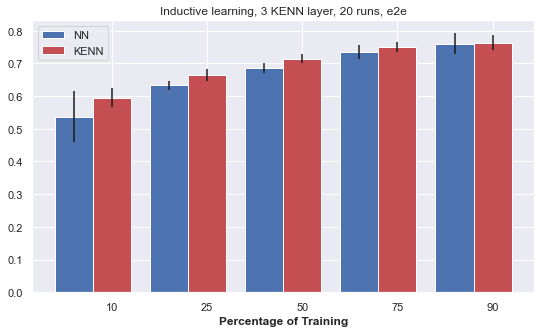

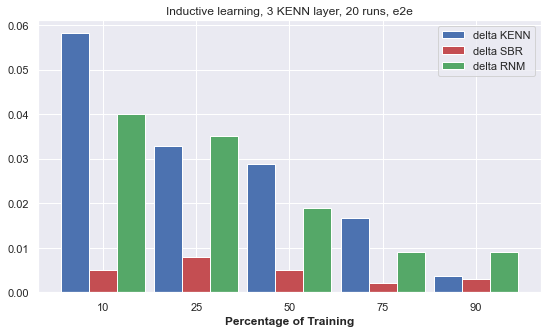

In [6]:
print_and_plot_results(
    history_20runs_inductive_3l, 
    plot_title="Inductive learning, 3 KENN layer, 20 runs, e2e",
    other_deltas='i')

## 3 KENN layers, 20 runs, greedy

In [7]:
with open('results/greedy/results_inductive(3layers)_20runs','rb') as input:
    history_20runs_inductive_3l_g = pickle.load(input)

In [8]:
# plot_losses(history_20runs_inductive_3l_g)

In [9]:
# plot_accuracies(history_20runs_inductive_3l_g)

== 10% ==
Mean Test Accuracy:	NN = 0.551107; KENN = 0.561288
Test Accuracy std:	NN = 0.028129; KENN = 0.030322
			Delta = 0.010181

== 25% ==
Mean Test Accuracy:	NN = 0.630314; KENN = 0.639010
Test Accuracy std:	NN = 0.014647; KENN = 0.016042
			Delta = 0.008696

== 50% ==
Mean Test Accuracy:	NN = 0.683152; KENN = 0.688919
Test Accuracy std:	NN = 0.013086; KENN = 0.013143
			Delta = 0.005767

== 75% ==
Mean Test Accuracy:	NN = 0.728080; KENN = 0.730254
Test Accuracy std:	NN = 0.023707; KENN = 0.023267
			Delta = 0.002174

== 90% ==
Mean Test Accuracy:	NN = 0.752719; KENN = 0.754079
Test Accuracy std:	NN = 0.029636; KENN = 0.030021
			Delta = 0.001360



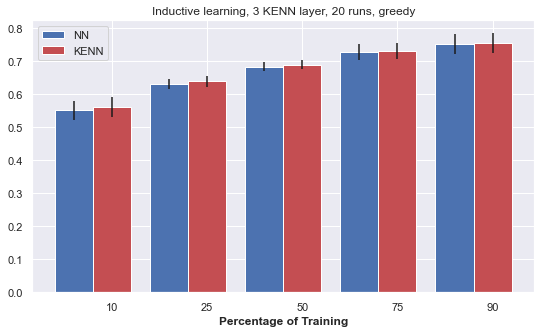

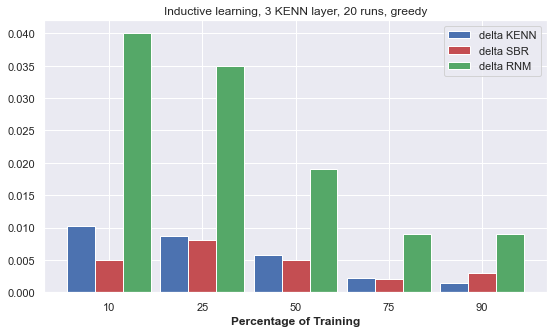

In [10]:
print_and_plot_results(
    history_20runs_inductive_3l_g, 
    plot_title="Inductive learning, 3 KENN layer, 20 runs, greedy",
    other_deltas='i')

# Transductive Learning

## 3 KENN layers, 20 runs, e2e

In [11]:
with open('results/e2e/results_transductive(3layers)_20runs','rb') as input:
    history_20runs_transductive_3l = pickle.load(input)

In [12]:
# plot_losses(history_20runs_transductive_3l)

In [13]:
# plot_accuracies(history_20runs_transductive_3l)

== 10% ==
Mean Test Accuracy:	NN = 0.537035; KENN = 0.657816
Test Accuracy std:	NN = 0.078546; KENN = 0.011278
			Delta = 0.120782

== 25% ==
Mean Test Accuracy:	NN = 0.632689; KENN = 0.697585
Test Accuracy std:	NN = 0.013664; KENN = 0.011605
			Delta = 0.064895

== 50% ==
Mean Test Accuracy:	NN = 0.685930; KENN = 0.744565
Test Accuracy std:	NN = 0.014099; KENN = 0.013363
			Delta = 0.058635

== 75% ==
Mean Test Accuracy:	NN = 0.733998; KENN = 0.782548
Test Accuracy std:	NN = 0.021081; KENN = 0.015092
			Delta = 0.048551

== 90% ==
Mean Test Accuracy:	NN = 0.759970; KENN = 0.801360
Test Accuracy std:	NN = 0.031851; KENN = 0.027720
			Delta = 0.041390



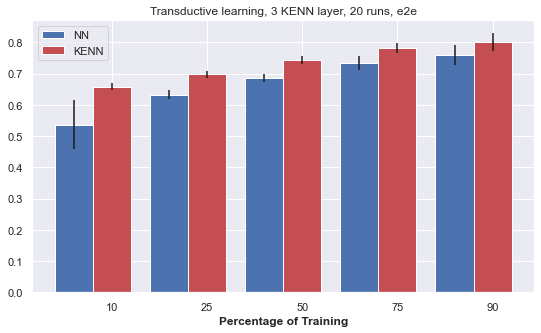

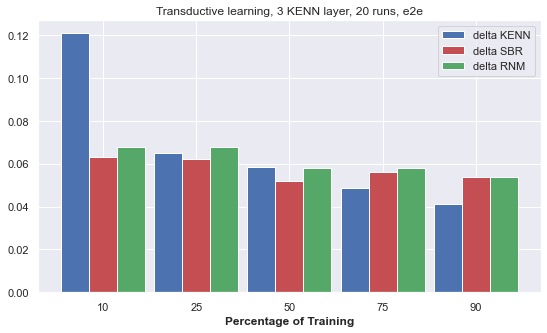

In [14]:
print_and_plot_results(
    history_20runs_transductive_3l, 
    plot_title="Transductive learning, 3 KENN layer, 20 runs, e2e",
    other_deltas='t')

## 3 KENN layers, 20 runs, greedy

In [15]:
with open('results/greedy/results_transductive(3layers)_20runs','rb') as input:
    history_20runs_transductive_3l_g = pickle.load(input)

In [16]:
# plot_losses(history_20runs_transductive_3l_g)

In [17]:
# plot_accuracies(history_20runs_transductive_3l_g)

== 10% ==
Mean Test Accuracy:	NN = 0.551107; KENN = 0.562982
Test Accuracy std:	NN = 0.028129; KENN = 0.031057
			Delta = 0.011875

== 25% ==
Mean Test Accuracy:	NN = 0.630314; KENN = 0.642230
Test Accuracy std:	NN = 0.014647; KENN = 0.015915
			Delta = 0.011916

== 50% ==
Mean Test Accuracy:	NN = 0.683152; KENN = 0.693810
Test Accuracy std:	NN = 0.013086; KENN = 0.012990
			Delta = 0.010658

== 75% ==
Mean Test Accuracy:	NN = 0.728080; KENN = 0.735930
Test Accuracy std:	NN = 0.023707; KENN = 0.022647
			Delta = 0.007850

== 90% ==
Mean Test Accuracy:	NN = 0.752719; KENN = 0.760725
Test Accuracy std:	NN = 0.029636; KENN = 0.030848
			Delta = 0.008006



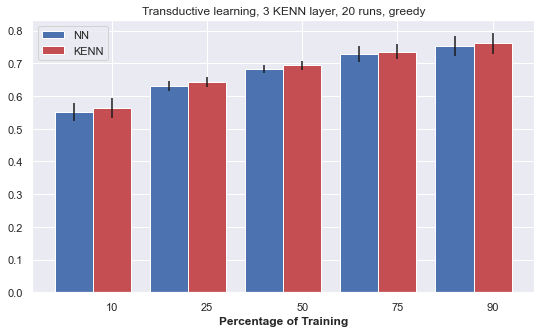

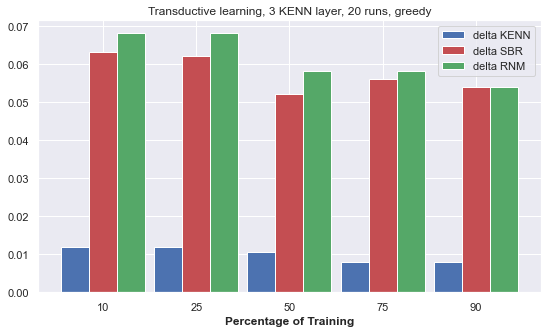

In [18]:
print_and_plot_results(
    history_20runs_transductive_3l_g, 
    plot_title="Transductive learning, 3 KENN layer, 20 runs, greedy",
    other_deltas='t')

## Clause Weights Inspection
- Vedere come variano i clause weights al variare della training dimension

In [67]:
from training_inductive import train_and_evaluate_kenn_inductive
from training_transductive import train_and_evaluate_kenn_transductive
from pre_elab import generate_dataset
import matplotlib.pyplot as plt

In [21]:
topics = ["AI","Agents","DB","HCI","IR","ML"]

In [62]:
generate_dataset(0.9, verbose=False)

C:\Users\ricca\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3347: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [63]:
history_ind = train_and_evaluate_kenn_inductive(0.9, verbose=False)

*CB_ES* Validation Accuracy didn't increase in the last 10 epochs
*CB_ES* delta: 0.00067454576
callback_early_stopping signal received at epoch= 42/300
Terminating training 
Test Accuracy: 0.7492446899414062


In [64]:
history_tra = train_and_evaluate_kenn_transductive(0.9, verbose=False)

*CB_ES* Validation Accuracy didn't increase in the last 10 epochs
*CB_ES* delta: 0.0008431673
callback_early_stopping signal received at epoch= 36/300
Terminating training 
Test Accuracy: 0.8006042242050171


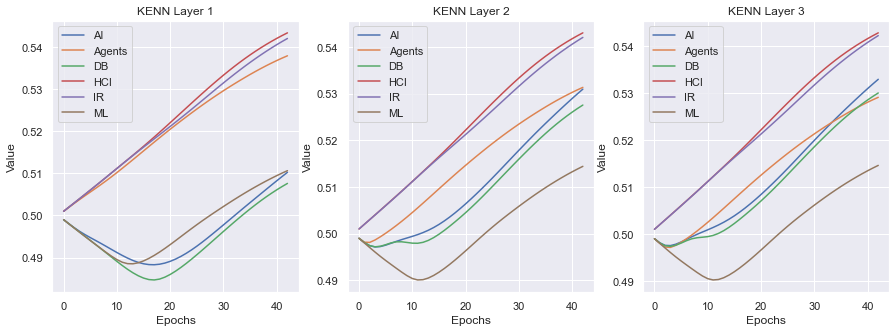

In [68]:
plot_clause_weights(history_ind)

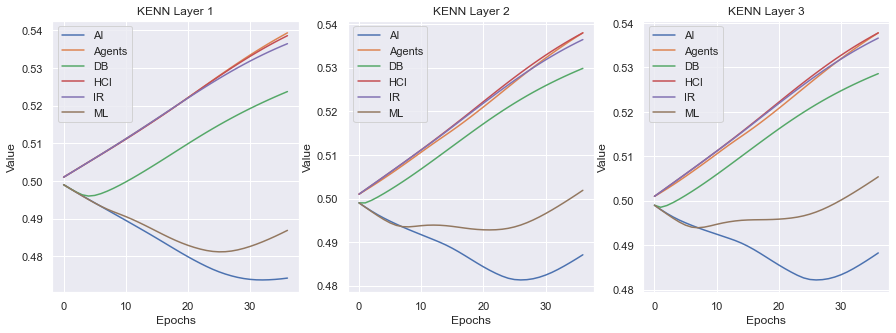

In [69]:
plot_clause_weights(history_tra)